In [1]:
%load_ext autoreload
%autoreload 2

from primitives.primitives import *
from primitives.tv_model import *
from primitives.spinful import *

from cirq import Circuit, LineQid, measure, sample, Simulator
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy.constants import hbar

simulator = Simulator()

In [2]:
def add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop):
    rows, cols, _ = qudits.shape

    for row in range(rows):
        for col in range(cols):
            # horizontal interaction
            if col != cols - 1:
                a = qudits[row][col]
                b = qudits[row][col+1]
                evolution_circuit.append(ev_xhop(a[0], b[0]))  # spin up
                evolution_circuit.append(ev_xhop(a[1], b[1]))  # spin down
            # vertical interaction
            if row != rows - 1:
                a = qudits[row][col]
                b = qudits[row+1][col]
                evolution_circuit.append(ev_yhop(a[0], b[0]))  # spin up
                evolution_circuit.append(ev_yhop(a[1], b[1]))  # spin down

def add_numbers_circuit(qudits, evolution_circuit, ev_num):
    rows, cols, _ = qudits.shape
    
    # On-site part
    for row in range(rows):
        for col in range(cols):
            evolution_circuit.append(ev_num(qudits[row][col][0], qudits[row][col][1]))

def evolve(qudits, temps, initial, J, U):

    if len(temps) > 1:
        ev_num = evolve_gate(SpinfulNumberGate)(C=U, t = temps[1]-temps[0])
        ev_xhop = evolve_gate(HopXGate)(C=J, t = (temps[1]-temps[0])/2)
        ev_yhop = evolve_gate(HopYGate)(C=J, t = (temps[1]-temps[0])/2)
        
    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:
            add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop)
            add_numbers_circuit(qudits, evolution_circuit, ev_num)
            add_hopping_circuit(qudits, evolution_circuit, ev_xhop, ev_yhop),

        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

### Evolve a lattice

In [3]:
def get_spin_plaquettes(qudits):
    rows, cols, _ = qudits.shape
    plaquettes = []
    for row in range(rows):
        for col in range(cols):
            if col != cols - 1 and row != rows - 1:
                pl = [
                    qudits[row][col][0],
                    qudits[row][col + 1][0],
                    qudits[row + 1][col + 1][0],
                    qudits[row + 1][col][0],
                ]
                plaquettes.append(pl)
                pl = [
                    qudits[row][col][1],
                    qudits[row][col + 1][1],
                    qudits[row + 1][col + 1][1],
                    qudits[row + 1][col][1],
                ]    
                plaquettes.append(pl)
    return plaquettes

In [4]:
J = -1
U = 0.5

rows = 2
columns = 3
qudits = np.array(LineQid.range(rows * columns * 2, dimension=4)).reshape(rows, columns, 2)

In [8]:
final_T = 0.4
num_steps = 2
dt = 5 # final_T / num_steps

temps = np.arange(0, final_T+dt/2, dt)
print(temps)

plaquettes = get_spin_plaquettes(qudits)
projected_subspace = [Project_Constraint()(*pl) for pl in plaquettes]


coeffs = [1, 1] #+4j, 1+2j]

initial_state = [
    #AddDiagTriple(*coeffs)(qudits[0][0][0], qudits[0][1][0], qudits[1][1][0]),
    AddHorizontalPair()(qudits[0][0][1], qudits[0][1][1]),
]

initial_circuit = [*projected_subspace, *initial_state]

# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, J, U)

[0.]


In [9]:
results[0][0]

┌────┐   ┌────┐
0 (d=4): ─────P+────────────────────
              │
1 (d=4): ─────┼─P+─────────────f+───
              │ │              │
2 (d=4): ─────P+┼──────P+──────┼────
              │ │      │       │
3 (d=4): ─────┼─P+─────┼─P+────f+───
              │ │      │ │
4 (d=4): ─────┼─┼──────P+┼──────────
              │ │      │ │
5 (d=4): ─────┼─┼──────┼─P+─────────
              │ │      │ │
6 (d=4): ─────P+┼──────┼─┼──────────
              │ │      │ │
7 (d=4): ─────┼─P+─────┼─┼──────────
              │ │      │ │
8 (d=4): ─────P+┼──────P+┼──────────
                │      │ │
9 (d=4): ───────P+─────┼─P+─────────
                       │ │
10 (d=4): ─────────────P+┼──────────
                         │
11 (d=4): ───────────────P+─────────
             └────┘   └────┘

In [10]:
v = results[0][1].state_vector()
(np.zeros(v.shape) == v).all()

False

### Operators

In [10]:
line_styles = ['-.', '--', '-.', ':']*3
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']*2

In [24]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    print(idx)
    for state in results:
        operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for idx, i in enumerate(evol_res):
    name = idx // 2
    if idx % 2 == 1:
        name = str(name)+"'"
    plt.plot(temps, evol_res[i], label=f"plaquette {name}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

0



KeyboardInterrupt



### Numbers

0
1
2
3
4
5
6
7
8


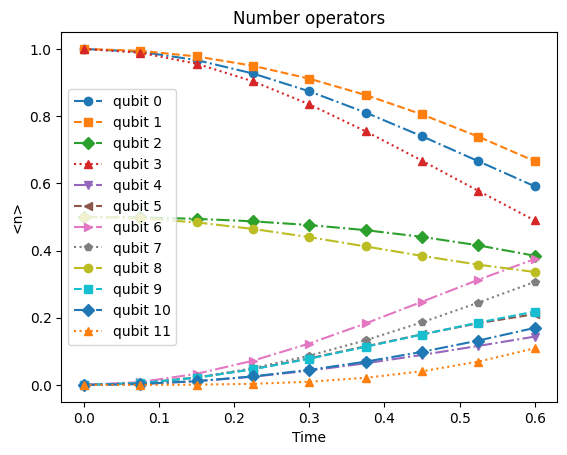

In [23]:
num_evol_res = []

for idx, state in enumerate(results):
    print(idx)
    nums = compute_state_exp_numbers(qudits, state)
    num_evol_res.append(nums)
    
num_evol_res = np.array(num_evol_res)

for i in range(len(qudits.flatten())):
    plt.plot(temps, num_evol_res[:,i], label=f"qubit {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [25]:
num_evol_res[0]

array([1. , 1. , 0.5, 1. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ])

In [26]:
np.sum(num_evol_res, axis=1)

array([4.        , 4.00000032, 3.99999973, 4.00000013, 4.00000051,
       4.00000037, 3.99999986, 4.00000009, 3.99999994])

### Hamiltonian

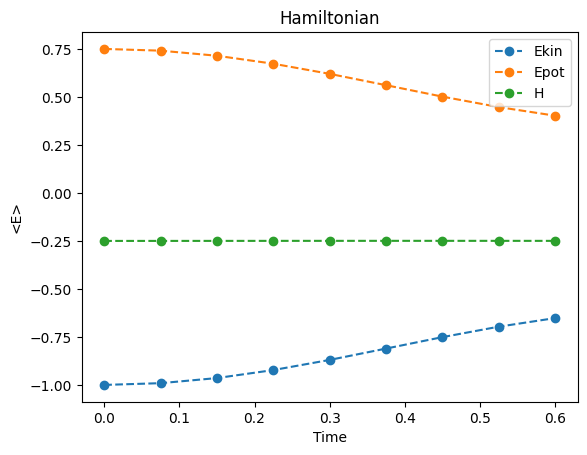

In [27]:
ekin = []
epot = []

for state in results:
    ham_k, ham_p = compute_state_exp_hamiltonian_fh(qudits, state, J, U)
    ekin.append(ham_k)
    epot.append(ham_p)

ekin = np.array(ekin)
epot = np.array(epot)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")
plt.plot(temps, ekin+epot, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [28]:
ekin, epot

(array([-1.        , -0.99087067, -0.9642923 , -0.92264466, -0.86976775,
        -0.81069619, -0.7511334 , -0.69667931, -0.65196701]),
 array([0.75      , 0.74091674, 0.71444623, 0.67292342, 0.62015376,
        0.56114603, 0.50158779, 0.44707805, 0.40226323]))

In [15]:
final_T = 0.6

nums_steps = [1, 2, 4, 8]


final_results_k = []
final_results_p = []
final_results_h = []
final_results_nums = []

for num_steps in nums_steps:
    print(f"Doing {num_steps} steps")
    
    dt = final_T / num_steps
    temps = np.arange(0, final_T+dt/2, dt)
    # results is a list of tuples, every tuple contains the circuit and the result shots
    results = evolve(qudits, temps, initial_circuit, J=J, U=U)

    ham_k, ham_p = compute_state_exp_hamiltonian_fh(qudits, results[-1], J, U)
    final_results_k.append(ham_k)
    final_results_p.append(ham_p)
    final_results_h.append(ham_k+ham_p)

    nums = compute_state_exp_numbers(qudits, results[-1])
    final_results_nums.append(nums)

Doing 1 steps
Doing 2 steps
Doing 4 steps
Doing 8 steps


Text(0.5, 1.0, 'Tot error on nums')

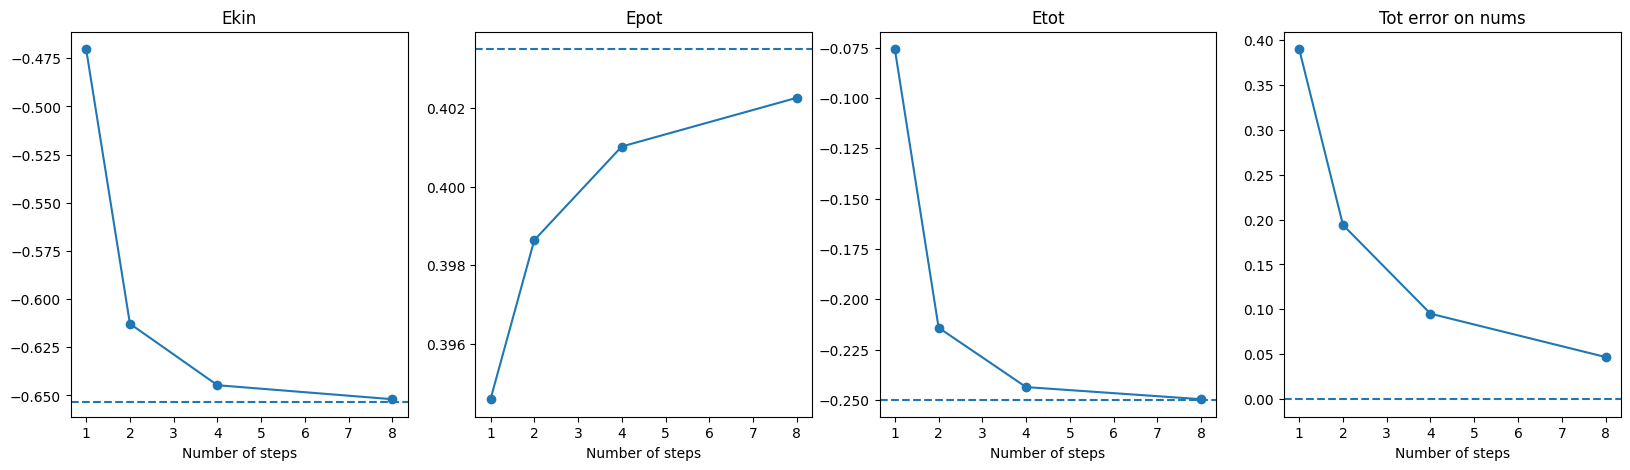

In [20]:
# Tmax = 0.6


nk_val_k = -0.6535
nk_val_p = 0.4035
nk_val_h = nk_val_k+nk_val_p

nk_numbers = np.array([0.593, 0.6637, 0.3805, 0.4916, 0.1461, 0.2107,
                       0.3784, 0.3077, 0.3389, 0.2278, 0.1631, 0.0984])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

final_results_k = np.array(final_results_k)
final_results_p = np.array(final_results_p)

ax1.plot(nums_steps, final_results_k, "-o", label="Ekin")
ax1.axhline(nk_val_k, linestyle="--", label="NK kin")
ax1.set_xlabel("Number of steps")
ax1.set_title("Ekin")

ax2.plot(nums_steps, final_results_p, "-o", label="Epot")
ax2.axhline(nk_val_p, linestyle="--", label="NK pot")
ax2.set_xlabel("Number of steps")
ax2.set_title("Epot")

ax3.plot(nums_steps, final_results_h, "-o", label="Etot")
ax3.axhline(nk_val_h, linestyle="--", label="NK tot")
ax3.set_xlabel("Number of steps")
ax3.set_title("Etot")

num_error = [np.sum(np.abs(nk_numbers - i)) for i in final_results_nums]
ax4.plot(nums_steps, num_error, "-o", label="Etot")
ax4.axhline(0, linestyle="--", label="NK tot")
ax4.set_xlabel("Number of steps")
ax4.set_title("Tot error on nums")